In [6]:
# from google.colab import files
# files.upload()
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d chrisfilo/urbansound8k
# ! unzip urbansound8k.zip -d UrbanSounds8K

In [7]:
import os
import ipytest
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
from torch.utils.data import DataLoader
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import ipytest
from pathlib import Path

ipytest.autoconfig()

class_map = [
    'air conditioner', 'car horn', 'children playing', 'dog bark', 'drilling',
    'engine idling', 'gunshot', 'jackhammer', 'siren', 'street music'
]

def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = int(sr/1000 * max_ms)

    if (sig_len > max_len):
        # Truncate the signal to the given length
        sig = sig[:,:max_len]

    elif (sig_len < max_len):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)
    return (sig, sr)

def rechannel(aud, new_channel):
    sig, sr = aud
    if (sig.shape[0] == new_channel):
        # Nothing to do
        return aud
    elif (new_channel == 1):
        # Convert from stereo to mono by selecting only the first channel
        resig = sig[:1, :]
    else:
        # Convert from mono to stereo by duplicating the first channel
        resig = torch.cat([sig, sig])
    return ((resig, sr))

def resample(aud, newsr):
    sig, sr = aud
    if (sr == newsr):
        # Nothing to do
        return aud
    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
        # Resample the second channel and merge both channels
        retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
        resig = torch.cat([resig, retwo])
    return ((resig, newsr))

def show_spectrogram(audio):
    spectrogram = torchaudio.transforms.Spectrogram()(audio)[0]
    print("\nShape of spectrogram: {}".format(spectrogram.size()))
    plt.imshow(spectrogram.log2().numpy(), cmap='viridis', origin='lower')
    plt.show()

def load_audio_files(path, dataset):
    walker = [str(p) for p in Path(path).glob(f'*.wav')]
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        title, _ = os.path.splitext(filename)
        fsID, classID, occurrenceID, sliceID = [
            int(n) for n in title.split('-')
        ]
        # Load audio
        waveform, sample_rate = pad_trunc(
            resample(rechannel(torchaudio.load(file_path), 1), 44100), 4000)
        assert waveform.shape == torch.Size(
            [1, 176400]), f'Error: waveform shape is {waveform.shape}'
        dataset.append([waveform[0], classID, title])

    return dataset

def create_spectrogram_images(trainloader, mode = "train"):
    length = len(trainloader)
    spectrogram = torchaudio.transforms.Spectrogram()
    timeMask = torchaudio.transforms.TimeMasking(time_mask_param=80)
    freqMask = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
    num_TimeMask = 4
    num_FreqMask = 4
    num_FreqTimeMask = 4

    for i, data in enumerate(trainloader):
        waveform = data[0]
        classID = data[1].item()
        title = data[2][0]
        directory = f'./UrbanSounds8K/spectrograms/{mode}/{class_map[classID]}/'
        if(not os.path.isdir(directory)):
            os.makedirs(directory, mode=0o777, exist_ok=True)

        spectrogram_tensor = (spectrogram(waveform) + 1e-12).log2()

        assert spectrogram_tensor.shape == torch.Size([1, 201, 883]), f"Spectrogram size mismatch! {spectrogram_tensor.shape}"

        if mode =="train":
            # create transformed waveforms
            for a in range(num_TimeMask):
                masked_spectrogram_tensor = timeMask(spectrogram_tensor)
                np.save(f'{directory}{title}-tm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqMask):
                masked_spectrogram_tensor = freqMask(spectrogram_tensor)
                np.save(f'{directory}{title}-fm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqTimeMask):
                masked_spectrogram_tensor = freqMask(timeMask(spectrogram_tensor))
                np.save(f'{directory}{title}-ftm{a}_spec',
                        masked_spectrogram_tensor.flipud())

        np.save(f'{directory}{title}-org_spec', spectrogram_tensor.flipud())
        # break
        if i % 1000 == 0:
            print(f'{mode}: {i}/{length}')

    return (length)*(num_TimeMask + num_FreqMask + num_FreqTimeMask + 1) if mode=="train" else (length)


In [8]:
%%ipytest

def test_load():
    walker = sorted(str(p) for p in Path("./test/").glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        assert torchaudio.load(file_path) 

def test_pad_trunc():
    target_length = 4
    assert len(pad_trunc(torchaudio.load('./test/1_44100_0830.wav'), target_length * 1000)[0][0]) == 44100*target_length
    assert len(pad_trunc(torchaudio.load('./test/2_44100_2250.wav'), target_length * 1000)[0][0]) == 44100*target_length
    assert len(pad_trunc(torchaudio.load('./test/2_44100_4000.wav'), target_length * 1000)[0][0]) == 44100*target_length

def test_rechannel():
    target_channel = 1
    assert rechannel(torchaudio.load('./test/1_44100_0830.wav'), target_channel)[0].shape[0] == target_channel
    assert rechannel(torchaudio.load('./test/2_44100_4000.wav'), target_channel)[0].shape[0] == target_channel

def test_resample():
    target_sr = 44100
    assert len(resample(torchaudio.load('./test/1_11025_4000.wav'), target_sr)[0][0]) == 4*target_sr
    assert len(resample(torchaudio.load('./test/1_44100_0830.wav'), target_sr)[0][0]) == 0.830*target_sr
    assert len(resample(torchaudio.load('./test/1_96000_0310.wav'), target_sr)[0][0]) == 0.310*target_sr


....                                                                                         [100%]
4 passed in 0.05s


In [9]:
main_path = './UrbanSounds8K/'
directory = [str(p) for p in Path(main_path).glob('fold*')][0:1]

audio_dataset = []

for path in directory:
    print("Loading ", path)
    audio_dataset = load_audio_files(path, audio_dataset)

print(f"Length of dataset: {len(audio_dataset)}")

Loading  UrbanSounds8K\fold1
Length of dataset: 873


In [10]:
train_size = int(0.8 * len(audio_dataset))
val_size = len(audio_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    audio_dataset, [train_size, val_size])

audio_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

num_train = create_spectrogram_images(audio_dataloader, "train")

audio_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

num_val = create_spectrogram_images(audio_dataloader, "val")

train: 0/698
val: 0/175


In [11]:
%%ipytest

def test_spectrogram_generation_train():
    assert len([
        str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')
    ]) == len(class_map)

    sum = 0
    dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')]
    for path in dir:
        num = len([str(p) for p in Path(path).glob('*')])
        sum += num
    assert sum == num_train

def test_spectrogram_generation_val():
    assert len([
        str(p) for p in Path('./UrbanSounds8K/spectrograms/val').glob('*')
    ]) == len(class_map)

    sum = 0
    dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/val').glob('*')]
    for path in dir:
        num = len([str(p) for p in Path(path).glob('*')])
        sum += num

    assert sum == num_val

..                                                                                           [100%]
2 passed in 0.27s


-39.863136   10.297472


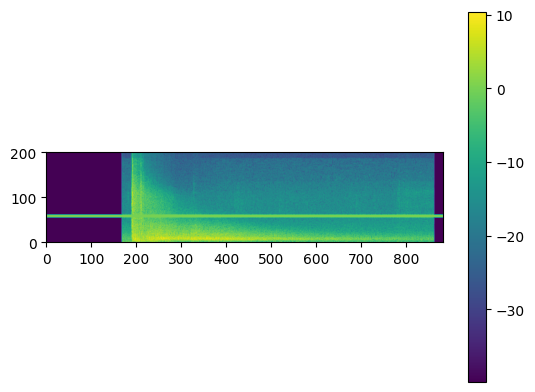

In [12]:
test_load = np.load(
    './UrbanSounds8K/spectrograms/train/gunshot/122690-6-0-0-fm0_spec.npy')
plt.imshow(test_load[0], origin="lower")
plt.colorbar()
print(test_load.min(), " ", test_load.max())

Debug

In [13]:
# filename = "./UrbanSounds8K/fold1/102305-6-0-0.wav"
# waveform, sample_rate = rechannel(torchaudio.load(filename), 1)
# fig, axs = plt.subplots(2)
# axs[0].plot(waveform.t().numpy())
# show_spectrogram(waveform)

In [14]:
# waveform, sr = pad_trunc(rechannel(torchaudio.load(filename), 1), 4000)
# fig, axs = plt.subplots(2)
# axs[0].plot(waveform.t().numpy())
# show_spectrogram(waveform)

In [15]:
# audio_dataset = []
# sum = 0

# main_path = './UrbanSounds8K/spectrograms/'

# dir = [str(p) for p in Path(main_path).glob('*')]
# for path in dir:
#   print('Loading: '+ path)
#   num = len([str(p) for p in Path(path).glob('*')])
#   sum += num
#   print(num)

# sum